Elastic Modulus and Poissons Ratio Fitting & Viewer

In [ ]:
"""Fits the elastic modulus and Poisson's ratio then shows the fitments"""
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt; import numpy as np
from pvc_tensile_experiment.Functions import *

def LinearFit(x, a, b):
    return a*x + b

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)

# create a dataframe to save the data 
df = pd.DataFrame(columns = ["Plasticizer", "Elastic Modulus (Pa)", "Poissons Ratio", "Bulk Modulus"])
i = 0

# plot parameters
markerSize = 2.4
titleSize = 15
axisSize = 11
legendSize = 11

# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # compile all the data  
    _, axStrain, _, transStrain, stress = InstronDataCompile('Elastic Data', plastiRatio)
    axStrain = axStrain*100
    transStrain = transStrain*100

    # define the elastic region
    elasRegion = np.where(axStrain < 25) 

    # curve fit the elastic region. 
    xfit = np.linspace(axStrain[elasRegion][0], axStrain[elasRegion][-1])
    poptE, pcovE = curve_fit(LinearFit, axStrain[elasRegion], stress[elasRegion]*1e8)
    poptP, pcovP = curve_fit(LinearFit, axStrain[elasRegion], transStrain[elasRegion])

    # plot engineering stress vs strain
    plt.figure(0)
    plt.scatter(axStrain[elasRegion], stress[elasRegion]*1e8, s = markerSize, label = f'{plastiRatio}, $R^2$ = {np.round(RSquared(stress[elasRegion]*1e8, LinearFit(axStrain[elasRegion], poptE[0], poptE[1])), 3)}')
    plt.plot(xfit, LinearFit(xfit, poptE[0], poptE[1]), 'black')
    plt.xlabel('Axial Strain (%)', fontsize = axisSize)
    plt.ylabel('Stress (Pa)', fontsize = axisSize)
    plt.title(f'Elastic Modulus', fontsize = titleSize)
    plt.ticklabel_format(axis='both', style='sci',useMathText=True)
    plt.legend(fontsize = legendSize)

    # plot poissons ratio
    plt.figure(1)
    plt.scatter(axStrain[elasRegion], transStrain[elasRegion], s = markerSize, label = f'{plastiRatio}, $R^2$ = {np.round(RSquared(transStrain[elasRegion], LinearFit(axStrain[elasRegion], poptP[0], poptP[1])), 3)}')
    plt.plot(xfit, LinearFit(xfit, poptP[0], poptP[1]), linewidth = 2)
    plt.xlabel('Axial Strain (%)', fontsize = axisSize)
    plt.ylabel('Transverse Strain (%)', fontsize = axisSize)
    plt.title(f'Poisson\'s Ratio', fontsize = titleSize)
    plt.legend(fontsize = legendSize)

    df.loc[i] = [plastiRatio, poptE[0], poptP[0], poptE[0]/2/(1 - 2*poptP[0])]
    i = i + 1
plt.show()

df.to_csv(f"Data/PVC Gel Material Parameters.csv", sep = ',', header = True, index = False)

Elastic Modulus Data Excel Combiner & Exporter

In [ ]:
"""Elastic modulus and Poissons' ratio parameter exporter"""
from pvc_tensile_experiment.Functions import *; import numpy as np

# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # compile all the data  
    _, axStrain, _, transStrain, stress = InstronDataCompile('Elastic Data', plastiRatio)

    # find the elastic region
    elasRegion = np.where(axStrain < 0.3) 

    # save the nominal stress and stretch data 
    df = pd.DataFrame(columns = ["Transverse Strain", "Eng. Axial Strain", "Eng. Stress (Pa)"])
    df["Transverse Strain"] = transStrain[elasRegion]
    df["Eng. Axial Strain"] = axStrain[elasRegion]
    df["Eng. Stress (Pa)"] = stress[elasRegion]    
    
    # df.to_csv(f"Data/{plastiRatio} Uniaxial Tensile Data.csv", sep = ',', header = True, index = False)


Concentration Dependance

In [ ]:
"""This fits power law between elastic modulus and gel concentration"""
from pvc_tensile_experiment.Functions import *
import pandas as pd; import numpy as np
from scipy.optimize import curve_fit

def LinearFit(x, a, b):
    return a*x + b

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)


# express the concentrations
concentration = np.array([2, 4, 6, 8])
# concentration = np.array([25.6, 14.6, 10.3, 7.9])

# preallocate the data dataframe
data = pd.DataFrame(columns = ['Elastic Modulus (Pa)'])
modulus = pd.read_csv(f'Data/PVC Gel Material Parameters.csv', usecols = [1], dtype = float)
data = pd.concat([data, modulus], ignore_index = True)

# add a concentration column 
data.insert(0, 'Plasticizer', concentration)

# plot parameters
markerSize = 10
titleSize = 15
axisSize = 12
legendSize = 11

# fit the elastic modulus to the logrithmic conversion
params, _ = curve_fit(LinearFit, np.log10(data['Plasticizer'].to_numpy()), np.log10(data['Elastic Modulus (Pa)'].to_numpy()))
r2 = RSquared(np.log10(data['Elastic Modulus (Pa)'].to_numpy()), LinearFit(np.log10(data['Plasticizer'].to_numpy()), params[0], params[1]))

print(f'E_0 = {10**params[1]*100**params[0]}')
print(params)

# elastic modulus fitment
plt.scatter(data['Plasticizer'], data['Elastic Modulus (Pa)'], s = markerSize, label = f'E-slope $-{np.abs(np.round(params[0], 4))}$, r$^2$ = {np.round(r2, 4)}')
plt.plot(data['Plasticizer'], np.power(10, LinearFit(np.log10(data['Plasticizer'].to_numpy()), params[0], params[1])), linewidth = 1,  c = 'black')
plt.xlabel('Weight Ratio', fontsize = axisSize)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Elastic Modulus (Pa)', fontsize = axisSize)
plt.title('Elastic Modulus - Plasticizer Weight Ratio', fontsize = titleSize)
plt.legend(fontsize = legendSize)
10**params[1]

Hyperelastic Data and Incompressibilty Assumption Viewer

In [ ]:
"""This plots large strain stress-strain data and the incompressibility assumption"""
from pvc_tensile_experiment.Functions import InstronDataCompile
import matplotlib.pyplot as plt; import numpy as np

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)

# preallocate the suplots
fig, axs1 = plt.subplots(1,1, layout = "constrained")
fig, axs2 = plt.subplots(1,1, layout = "constrained")
fig, axs3 = plt.subplots(1,1, layout = "constrained")

# plot parameters
markerSize = 5
titleSize = 15
axisSize = 12
legendSize = 11

# plot the ideal incompressability condition. this doesn't effect the coefficient of determination
stretch = np.arange(1.0, 3.5, 0.01)
axs1.plot(stretch, np.sqrt(1/stretch), label = 'Theoretical Fit', c = 'k', linewidth = 1)
axs1.legend(fontsize = legendSize)

# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # read the processed data files 
    _, axStrain, _, transStrain, stress = InstronDataCompile(f'Hyperelastic Data/', plastiRatio)

    # read only up to 250 % strain
    indices = np.where(axStrain < 2.5) 
    indices = range(0, indices[0][-1], 25)
    axStrain = axStrain[indices]

    # find true strain and stress from engineering strain
    stretch = 1 + axStrain
    transverseStretch = 1 + transStrain[indices]
    stress = stress[indices]*1e6
    stressTrue = stress*stretch

    # print the coeff of determination per dataset
    coeffDet = RSquared(np.sqrt(1/stretch[np.isnan(stretch) == False]), -transverseStretch[np.isnan(stretch) == False] + 2)

    # plot inverse stretch ratio showing isotropic and incompressable
    axs1.scatter(stretch, -transverseStretch + 2, label = f'{plastiRatio}, $R^2$ = {np.round(coeffDet, 3)}', s = markerSize)
    axs1.set_xlabel('Axial Stretch Ratio', fontsize = axisSize)
    axs1.set_ylabel('Transverse Stretch Ratio', fontsize = axisSize)
    axs1.set_title("Transverse-Axial Stretch - Incompressibility Assumption", fontsize = titleSize)
    axs1.legend(fontsize = legendSize)

    # plot engineering stress-strain 
    axs2.scatter(axStrain*1e2, stress, s = markerSize, label = f'{plastiRatio}')   
    axs2.set_xlabel('Axial Strain (%)', fontsize = axisSize)
    axs2.set_ylabel('Stress (Pa)', fontsize = axisSize)
    axs2.set_title('Engineering Stress-Strain', fontsize = titleSize)
    axs2.legend(fontsize = legendSize)
    
    # plot true stress-strain
    axs3.scatter(stretch, stressTrue, s = markerSize, label = f'{plastiRatio}')
    axs3.set_xlabel('Stretch Ratio', fontsize = axisSize)
    axs3.set_ylabel('True Stress (Pa)', fontsize = axisSize)
    axs3.set_title('True Stress-Stretch', fontsize = titleSize)
    axs3.legend(fontsize = legendSize)
plt.show()

Strain Hardening

In [ ]:
from pvc_tensile_experiment.Functions import *
import matplotlib.pyplot as plt; import numpy as np

# preallocate the suplots
fig, axs2 = plt.subplots(1,1, layout = "constrained")

# plot parameters
markerSize = 5
titleSize = 15
axisSize = 12
legendSize = 11


# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:
    # import the processed data based on it's plasticizer content
    fileNames = [i for i in os.listdir(f'Data/Tensile Data/Hyperelastic Data') if i.find(f'{plastiRatio}') != -1]
    
    # preallocate the total data vector 
    Data = np.zeros([0, 5])

    for i in fileNames:
        axDist, axStrain, transDist, transStrain, stress = InstronDataReader('Hyperelastic Data', i)
        data = np.vstack([axDist, axStrain, transDist, transStrain, stress]).T
        Data = np.vstack([Data, data])
    axStrain = Data[::, 1]
    stress = Data[::, 4]

    # read only up to 250 % strain
    indices = np.where(axStrain < 2.5)[0] 
    axStrain = axStrain[indices]
    stress = stress[indices]*1e6*(1 + axStrain)

    indices = range(0, len(axStrain), 40)
    axStrain = axStrain[indices[0:-1]]
    stress = np.diff(stress[indices])

    # plot inverse stretch ratio showing isotropic and incompressable
    axs2.scatter(axStrain*100, stress, label = f'{plastiRatio}', s = markerSize)
    axs2.set_xlabel('Axial Strain (%)', fontsize = axisSize)
    axs2.set_ylabel('Modulus (Pa)', fontsize = axisSize)
    axs2.set_title("Modulus per Axial Strain", fontsize = titleSize)
    axs2.set_ylim([0, 25.7e3])
    axs2.legend(fontsize = legendSize) 
plt.show()

Hyperealastic Fitting

In [ ]:
"""True Stress- Strain Hyperelastic Model Fitting"""
import numpy as np; import scipy.optimize as opt
import matplotlib.pyplot as plt
from pvc_tensile_experiment.Functions import *

# define hyperelastic models
def NeoHookean(params, stretch):
    mu = params
    return mu*(stretch**2 - 1/stretch)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch**2 - 1/stretch)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch**2 - 1/stretch)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def Ogden(params, stretch):
    mu, alpha, mu1, alpha1, mu2, alpha2 = params
    return 2*mu/alpha*(stretch**(alpha) - stretch**(-alpha/2)) + 2*mu1/alpha1*(stretch**(alpha1) - stretch**(-alpha1/2)) + 2*mu2/alpha2*(stretch**(alpha2) - stretch**(-alpha2/2))

def Gent(params, stretch):
    mu, Jm = params
    return mu*(stretch**2 - 1/stretch)*(Jm/(Jm - (stretch**2 + 2/stretch - 3)))

def ExtendedTube(params, stretch):
    Gc, Ge, beta, delta = params
    I1 = stretch**2 + 2/stretch
    return Gc*(stretch**2 - 1/stretch)*((1 + (1 + I1**2 - 4*I1)*delta**2 + (5*I1 - I1**2 - 6)*delta**4)/(1 - (I1 - 3)*delta**2)**2) - 2*Ge/beta*(stretch**(-beta) - stretch**(beta/2))


# define the model fitting function
def FitModel(model, stretch, trueStress, boundaries):
    # define the residual function and the NRMS function
    def Residuals(params):
        return model(params, stretch) - trueStress

    def NRMS(params):
        return np.sqrt(np.mean(Residuals(params)**2))/np.mean(trueStress)

    # run the genetic algorithm 10 times and store the results
    optInitialGuess = np.zeros([0, len(boundaries)])
    for i in range(0, 5):
        initialGuess = opt.differential_evolution(NRMS, bounds = boundaries, popsize = 500).x
        optInitialGuess = np.vstack([optInitialGuess, initialGuess])

    # average the genetic algorithm then pass results to the LM method
    optInitialGuess = np.average(optInitialGuess, axis = 0)
    optParams, _ = opt.least_squares(Residuals, optInitialGuess, method = 'lm', max_nfev = 500).x, None
    return optParams

# compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)


# define the plasticizer ration we want
plastiRatio = ['P2', 'P4', 'P6', 'P8']

for i in plastiRatio:
    # compile all the data  
    _, axStrain, _, transStrain, stress = InstronDataCompile('Hyperelastic Data', i)
   
    # read only up to 250 % strain
    indices = np.where(axStrain < 2.5) 
    indices = range(0, indices[0][-1], 25)

    # convert to true stress-strain
    stretch = 1 + axStrain[indices]
    trueStress = stress[indices]*stretch*1e6

    # plot parameters
    markerSize = 4
    titleSize = 15
    axisSize = 11
    legendSize = 11

    # models and initial guesses
    models = {"Neo-Hookean": (NeoHookean, [(0.1, 5e7)]),
                "Mooney-Rivlin": (MooneyRivlin, ([1e3, 1e6], [-1e6, 1e4])),
                "Yeoh": (Yeoh,  ([1e2, 1e6], [-1e5, 1e1], [1e1, 1e3])),
                "Gent": (Gent, ([1e1 , 1e6], [1, 200])),
                "Ogden": (Ogden, ([1e3, 1e7], [-5, -0.1], [1e2, 1e6], [0.1, 5], [1e1, 1e6], [1, 5])),
                "Extended Tube": (ExtendedTube, ([1, 10.0e6], [100, 5e6], [0.1, 10], [1e-7, 0.1]))
                }

    # create a datafrom store all the terms and their fitments. 
    Data = pd.DataFrame(['Model', 'R^2', 'Terms'])
    
    # Fit models
    fitResults = {}  
    for name, (model, boundaries) in models.items():
        print(name)
        params = FitModel(model, stretch, trueStress, boundaries)
        r2 = RSquared(trueStress, model(params, stretch))
        fitResults[name] = (params, r2)
        Data = pd.concat([Data, pd.Series([name, r2, params])], ignore_index = True, axis = 1)
        print(Data)

    # transpose the data then insert header to identify the model, r2, and terms.
    Data = Data.T
    Data.to_csv(f'Data/{i} PVC Gel Hyperelastic Parameters.csv', header = True, index = None)

    # Plot results
    plt.figure(figsize = (8, 6))
    plt.scatter(stretch, trueStress, s = markerSize, label = "Data", color = "black")

    for name, (params, r2) in fitResults.items():
        plt.plot(stretch, models[name][0](params, stretch), label = f'{name}, $R^2$: {np.round(r2, 3)}', linewidth = 1.5)

    plt.xlabel("Stretch Ratio", fontsize = axisSize)
    plt.ylabel("True Stress", fontsize = axisSize)
    plt.legend(fontsize = legendSize)
    plt.title(f'{i} PVC Gel Hyperelastic Model Fit', fontsize = titleSize)
    plt.show()

In [ ]:
"""True Stress- Strain Hyperelastic Model Fitting"""
import numpy as np; import scipy.optimize as opt
import matplotlib.pyplot as plt
from pvc_tensile_experiment.Functions import *

# define hyperelastic models
def NeoHookean(params, stretch):
    mu = params
    return mu*(stretch**2 - 1/stretch)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch**2 - 1/stretch)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch**2 - 1/stretch)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def Ogden(params, stretch):
    mu, alpha, mu1, alpha1, mu2, alpha2 = params
    return 2*mu/alpha*(stretch**(alpha) - stretch**(-alpha/2)) + 2*mu1/alpha1*(stretch**(alpha1) - stretch**(-alpha1/2)) + 2*mu2/alpha2*(stretch**(alpha2) - stretch**(-alpha2/2))

def Gent(params, stretch):
    mu, Jm = params
    return mu*(stretch**2 - 1/stretch)*(Jm/(Jm - (stretch**2 + 2/stretch - 3)))

def ExtendedTube(params, stretch):
    Gc, Ge, beta, delta = params
    I1 = stretch**2 + 2/stretch
    return Gc*(stretch**2 - 1/stretch)*((1 + (1 + I1**2 - 4*I1)*delta**2 + (5*I1 - I1**2 - 6)*delta**4)/(1 - (I1 - 3)*delta**2)**2) - 2*Ge/beta*(stretch**(-beta) - stretch**(beta/2))


# define the plasticizer ration we want
plastiRatio = ['P2', 'P4', 'P6', 'P8']

for i in plastiRatio:
    # compile all the data  
    _, axStrain, _, transStrain, stress = InstronDataCompile('Hyperelastic Data', i)
   
    # read only up to 250 % strain
    indices = np.where(axStrain < 2.5) 
    indices = range(0, indices[0][-1], 25)

    # convert to true stress-strain
    stretch = 1 + axStrain[indices]
    trueStress = stress[indices]*stretch*1e6

    # plot parameters
    markerSize = 4
    titleSize = 15
    axisSize = 11
    legendSize = 11

    # models and initial guesses
    models = {"Neo-Hookean": (NeoHookean, [(0.1, 5e7)]),
                "Mooney-Rivlin": (MooneyRivlin, ([1e3, 1e6], [-1e6, 1e4])),
                "Yeoh": (Yeoh,  ([1e2, 1e6], [-1e5, 1e1], [1e1, 1e3])),
                "Gent": (Gent, ([1e1 , 1e6], [1, 200])),
                "Ogden": (Ogden, ([1e3, 1e7], [-5, -0.1], [1e2, 1e6], [0.1, 5], [1e1, 1e6], [1, 5])),
                "Extended Tube": (ExtendedTube, ([1, 10.0e6], [100, 5e6], [0.1, 10], [1e-7, 0.1]))
                }

    # create a datafrom store all the terms and their fitments. 
    Data = pd.DataFrame(['Model', 'R^2', 'Terms'])
    
    # Fit models
    fitResults = {}  
    for name, (model, boundaries) in models.items():
        print(name)
        params = FitModel(model, stretch, trueStress, boundaries)
        r2 = RSquared(trueStress, model(params, stretch))
        fitResults[name] = (params, r2)
        Data = pd.concat([Data, pd.Series([name, r2, params])], ignore_index = True, axis = 1)
        print(Data)

    # transpose the data then insert header to identify the model, r2, and terms.
    Data = Data.T
    Data.to_csv(f'Data/{i} PVC Gel Hyperelastic Parameters.csv', header = True, index = None)

    # Plot results
    plt.figure(figsize = (8, 6))
    plt.scatter(stretch, trueStress, s = markerSize, label = "Data", color = "black")

    for name, (params, r2) in fitResults.items():
        plt.plot(stretch, models[name][0](params, stretch), label = f'{name}, $R^2$: {np.round(r2, 3)}', linewidth = 1.5)

    plt.xlabel("Stretch Ratio", fontsize = axisSize)
    plt.ylabel("True Stress", fontsize = axisSize)
    plt.ticklabel_format(axis='both', style='sci',useMathText=True)
    plt.legend(fontsize = legendSize)
    plt.title(f'{i} PVC Gel Hyperelastic Model Fit', fontsize = titleSize)
    plt.show()

Normalized Root-Mean Squared Error Table and Hyperelastic Replotting

<string>:67: SyntaxWarning: invalid escape sequence '\{'
<>:67: SyntaxWarning: invalid escape sequence '\{'
<string>:67: SyntaxWarning: invalid escape sequence '\{'
<>:67: SyntaxWarning: invalid escape sequence '\{'
C:\Users\facci\AppData\Local\Temp\ipykernel_28904\3237356430.py:67: SyntaxWarning: invalid escape sequence '\{'
  hyperParams = pd.read_csv(f'Data\{i} PVC Gel Hyperelastic Parameters.csv', delimiter = ',', header = 1)


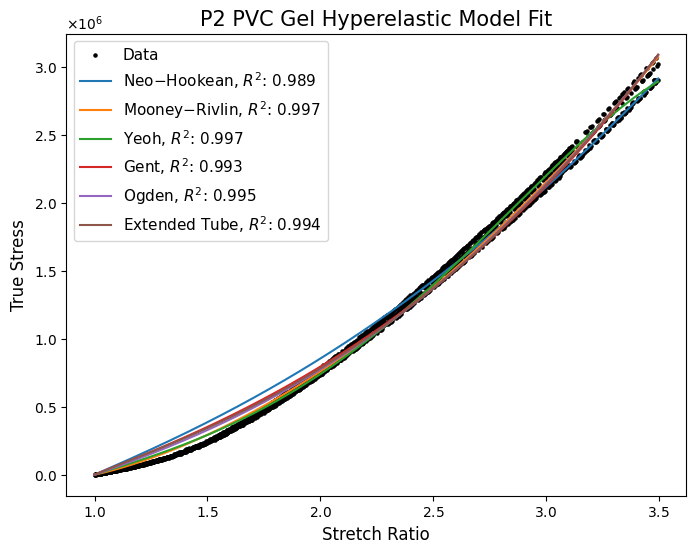

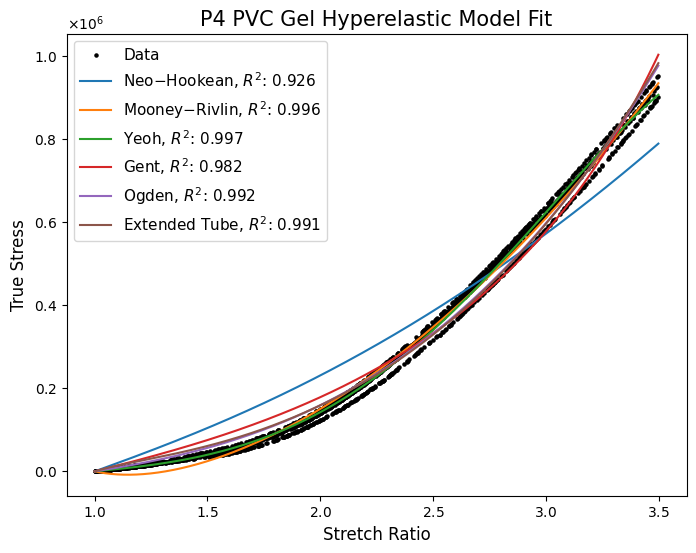

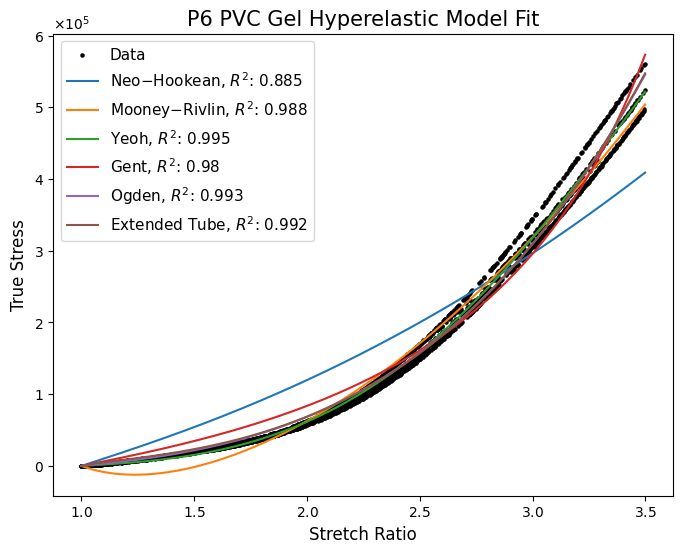

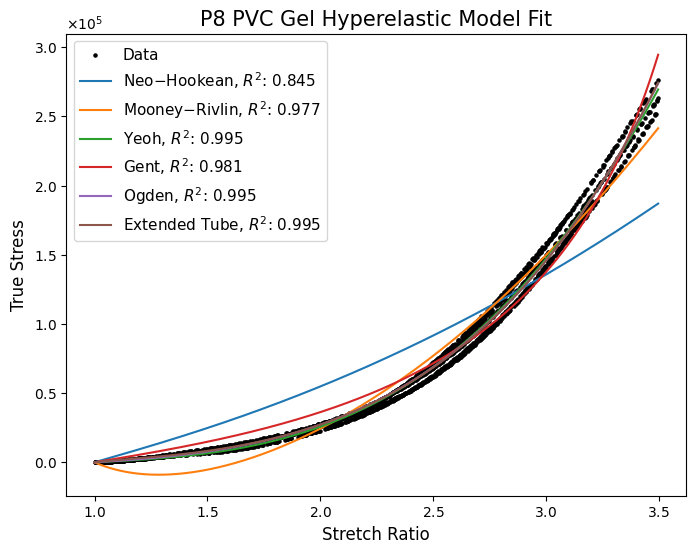

[[ 0.        ]
 [ 8.40233971]
 [ 4.52929726]
 [ 4.14588548]
 [ 6.63243354]
 [ 5.72968914]
 [ 6.3241062 ]
 [24.71370144]
 [ 6.00926434]
 [ 4.89724056]
 [12.2424951 ]
 [ 7.97362486]
 [ 8.58480937]
 [31.48064769]
 [10.12577655]
 [ 6.85107458]
 [13.18022893]
 [ 8.02864706]
 [ 8.20670926]
 [37.57736143]
 [14.34526276]
 [ 6.63200099]
 [13.29715619]
 [ 6.8750826 ]
 [ 6.89754989]]


In [86]:
"""This section uses the fitted curve parameters to show the normalized root mean square errors"""
import numpy as np; import pandas as pd
import matplotlib.pyplot as plt
from pvc_tensile_experiment.Functions import *


# define hyperelastic models
def NeoHookean(params, stretch):
    mu = params
    return mu*(stretch**2 - 1/stretch)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch**2 - 1/stretch)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch**2 - 1/stretch)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def Ogden(params, stretch):
    mu, alpha, mu1, alpha1, mu2, alpha2 = params
    return 2*mu/alpha*(stretch**(alpha) - stretch**(-alpha/2)) + 2*mu1/alpha1*(stretch**(alpha1) - stretch**(-alpha1/2)) + 2*mu2/alpha2*(stretch**(alpha2) - stretch**(-alpha2/2))

def Gent(params, stretch):
    mu, Jm = params
    return mu*(stretch**2 - 1/stretch)*(Jm/(Jm - (stretch**2 + 2/stretch - 3)))

def ExtendedTube(params, stretch):
    Gc, Ge, beta, delta = params
    I1 = stretch**2 + 2/stretch
    return Gc*(stretch**2 - 1/stretch)*((1 + (1 + I1**2 - 4*I1)*delta**2 + (5*I1 - I1**2 - 6)*delta**4)/(1 - (I1 - 3)*delta**2)**2) - 2*Ge/beta*(stretch**(-beta) - stretch**(beta/2))

# define the plasticizer ration we want
plastiRatio = ['P2', 'P4', 'P6', 'P8']
fitResults = np.array([0]) 

for i in plastiRatio:
    # compile all the data  
    _, axStrain, _, _, stress = InstronDataCompile('Hyperelastic Data', i)
   
    # read only up to 250 % strain
    indices = np.where(axStrain < 2.5) 
    indices = range(0, indices[0][-1], 25)

    # convert to true stress-strain
    stretch = 1 + axStrain[indices]
    trueStress = stress[indices]*stretch*1e6

    # models and initial guesses
    models = {"Neo$-$Hookean": NeoHookean,
                "Mooney$-$Rivlin": MooneyRivlin,
                "Yeoh": Yeoh,
                "Gent": Gent,
                "Ogden": Ogden,
                "Extended Tube": ExtendedTube
                }
    
    plt.figure(figsize = (8, 6))
    plt.scatter(stretch, trueStress, s = markerSize, label = "Data", color = "black")
    plt.xlabel("Stretch Ratio", fontsize = axisSize)
    plt.ylabel("True Stress", fontsize = axisSize)
    plt.ticklabel_format(axis='both', style='sci',useMathText=True, scilimits= (0,5))
    plt.title(f'{i} PVC Gel Hyperelastic Model Fit', fontsize = titleSize)

    # load hyperelastic model parameters
    hyperParams = pd.read_csv(f'Data\{i} PVC Gel Hyperelastic Parameters.csv', delimiter = ',', header = 1)

    for name, model in models.items():
        dd = hyperParams[hyperParams['Model'] == name]['Terms'].to_list()
        dd = [i.split(',') for i in dd ][0]
        params = np.array(dd, dtype = float)

        
        # normalized root mean square determination
        nrms = np.sqrt(np.mean((model(params, stretch) - trueStress)**2))/np.mean(trueStress)*100
        fitResults = np.vstack([fitResults, nrms])

        # Plot results
        r2 = np.round(hyperParams[hyperParams['Model'] == name]['R^2'].to_numpy()[0], 3)
        plt.plot(stretch, model(params, stretch), label = f'{name}, $R^2$: {r2}', linewidth = 1.5)
 
    plt.legend(fontsize = legendSize)
    plt.show()

# fitResults = np.round(np.delete(fitResults,0).reshape(4,6), 2)
print(fitResults)


________________________

np.float64(0.989)

MISC Functions

Random Image Viewer

In [ ]:
import cv2

# pull the frame from the folder
frame = cv2.imread('Data/Tensile Data/Image Data/PVC P2 Test_5/156.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)


# setp and display the contours and centers
cv2.namedWindow('Inspection', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Inspection', 960, 540)
cv2.imshow('Inspection', frame)
cv2.waitKey(0)

P2 and P8 comparison viewer

In [ ]:
from pvc_tensile_experiment.Functions import InstronDataCompile
import matplotlib.pyplot as plt; import numpy as np

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)

# preallocate the suplots
fig, axs1 = plt.subplots()
axs2 = axs1.twinx()

# plot parameters
markerSize = 5
titleSize = 15
axisSize = 12
legendSize = 11

# read the P2 processed data files 
_, axStrain, _, transStrain, stress = InstronDataCompile(f'Hyperelastic Data/', 'P2')

# read only up to 250 % strain
indices = np.where(axStrain < 2.5) 
indices = range(0, indices[0][-1], 25)
P2axStrain = axStrain[indices]
P2stress = stress[indices]*1e6

# read the P8 processed data files 
_, axStrain, _, transStrain, stress = InstronDataCompile(f'Hyperelastic Data/', 'P8')

# read only up to 250 % strain
indices = np.where(axStrain < 2.5) 
indices = range(0, indices[0][-1], 25)
P8axStrain = axStrain[indices]
P8stress = stress[indices]

# plot engineering stress-strain 
axs1.scatter(P2axStrain*1e2, P2stress, s = markerSize, label = f'P2')   
axs2.scatter(P8axStrain*1e2, P8stress, s = markerSize, c = 'tab:red', label = f'P8')   

axs1.set_xlabel('Strain (%)', fontsize = axisSize)
axs1.set_ylabel('Stress (Pa)', fontsize = axisSize)
axs2.set_ylabel('Stress (Pa)', c = 'tab:red', fontsize = axisSize)
axs2.tick_params(axis = 'y', labelcolor = 'tab:red')

axs1.set_title('P2 and P8 Engineering Stress-Strain Comparison', fontsize = titleSize)
axs1.legend(fontsize = legendSize)
axs2.legend(loc = 'lower right',fontsize = legendSize)
plt.show()
